In [2]:
# Imports 

import joblib
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


In [3]:
# Chargement des données
root_folder = "C:/Users/user/Downloads/SASED/data"


def extract_features(y, sr):

    # Duration
    duration = librosa.get_duration(y=y, sr=sr)
    
    # Mel-frequency Cepstral Coefficients (MFCCs)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mel_spec = librosa.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000), ref=np.max)
    delta_mfcc = librosa.feature.delta(mfccs)

    # Chroma Features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    
    # Zero-crossing rate
    zcr = librosa.feature.zero_crossing_rate(y)
    
    # Spectral centroid : brightness of sound
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

    # Bandwidth : Spread of frequencies around the centroid
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)

    # Rolloff : Frequency below which a certain % of the total spectral energy lies
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)

    # Flatness : Tonal vs. noisy quality (close to 1: noisy)
    flatness = librosa.feature.spectral_flatness(y=y)

    # Contrast : Difference in energy between peaks and valleys in spectrum
    contrast = librosa.feature.spectral_contrast(y=y)
    
    # RMS energy
    rms = librosa.feature.rms(y=y)

    # tempo
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    

    return np.hstack([mfccs.mean(axis=1), chroma.mean(axis=1), zcr.std(), zcr.mean(), centroid.mean(), centroid.std(), rms.mean(), rms.std(),
                      bandwidth.mean(), bandwidth.std(), rolloff.mean(), rolloff.std(), flatness.mean(), flatness.std(), tempo,
                      contrast.mean(), contrast.std(), delta_mfcc.mean(axis=1), mel_spec.mean(), mel_spec.std(), duration])

In [4]:
from tqdm import tqdm
# Train set
X_train = []
y_train = []
train_path = root_folder + '/train/sound/'
lof_train = [f for f in listdir(train_path)]
for file in tqdm(lof_train):
    if file.lower().endswith('.wav'):
        wav_path = train_path + '/' + file
        #print(f"Processing {file}...")

        try:
            y, sr = librosa.load(wav_path, sr=None)
            feats = extract_features(y, sr)
            X_train.append(feats)
            label = file.split(".")[0][:-3]
            y_train.append(label)
        except Exception as e:
            print(f"Erreur sur {fname}: {e}")

100%|██████████| 220/220 [00:26<00:00,  8.28it/s]


In [5]:
feature_names = (
    [f"mfcc_{i+1}_mean" for i in range(13)] +
    [f"chroma_{i+1}_mean" for i in range(12)] +
    ["zcr_std", "zcr_mean"] +
    ["centroid_mean", "centroid_std"] +
    ["rms_mean", "rms_std"] +
    ["bandwidth_mean", "bandwidth_std"] +
    ["rolloff_mean", "rolloff_std"] +
    ["flatness_mean", "flatness_std"] +
    ["tempo"] +
    ["contrast_mean", "contrast_std"] +
    [f"delta_mfcc_{i+1}_mean" for i in range(13)] +
    ["mel_spec_mean", "mel_spec_std"] +
    ["duration"]
)
X_train = pd.DataFrame(X_train, columns=feature_names)
X_train


,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,...,delta_mfcc_7_mean,delta_mfcc_8_mean,delta_mfcc_9_mean,delta_mfcc_10_mean,delta_mfcc_11_mean,delta_mfcc_12_mean,delta_mfcc_13_mean,mel_spec_mean,mel_spec_std,duration
0,-374.792755,140.685486,-22.768702,10.691028,11.266935,28.414036,20.567623,9.934408,-5.274453,-20.821169,...,0.140324,-0.246319,0.253460,-0.233609,0.170345,-0.145381,0.350494,-41.349903,18.152672,0.613991
1,-354.880005,145.709229,-19.790880,43.846081,67.305466,19.099997,-1.408821,-0.117860,0.504199,6.170728,...,0.330327,0.528842,0.433688,0.000684,1.300918,0.432549,0.466617,-44.580658,16.333199,0.372993
2,-365.981445,153.075287,-16.621624,28.834137,44.915955,9.562614,-4.000792,-1.152210,-9.830270,-6.968380,...,0.527888,0.005215,0.663084,0.651381,0.040098,0.425399,0.276807,-48.809013,16.535881,0.429002
3,-368.387817,147.542358,-22.850618,6.204122,43.693363,18.613615,-1.830239,-4.060287,0.426752,6.106246,...,0.104967,-0.002946,0.095774,0.388024,-0.077420,0.099775,0.127954,-49.091782,16.337309,1.032993
4,-374.212006,144.282562,-23.032028,1.411076,41.265362,33.529312,-7.110649,-25.114744,-17.255323,-24.185408,...,0.230998,0.570290,0.615406,0.452082,-0.041706,-0.082569,0.180627,-48.172096,17.601212,0.743991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,-352.061371,150.639282,3.898963,19.279781,34.260719,13.775576,7.164532,-5.797582,-2.457854,-20.004654,...,-0.019231,0.020034,0.058154,-0.011045,-0.057961,-0.023957,0.002159,-45.189392,15.648273,2.760998
216,-387.329163,111.356476,-9.242866,17.252768,14.358928,14.508772,-10.767764,-17.270653,-2.604261,-15.939982,...,-0.096794,0.058153,-0.036013,-0.025998,-0.103129,-0.112542,0.002841,-52.010170,14.582687,2.205011
217,-383.911133,129.793472,-3.518243,14.674668,13.479393,11.161960,-11.048513,-15.289004,-7.435698,-13.192748,...,-0.066735,-0.096187,-0.032106,-0.067064,0.082299,0.097353,-0.041405,-49.455975,15.476441,2.246009
218,-373.369598,120.140572,-7.573338,19.515631,3.755463,0.498491,-18.813906,-12.738475,-14.049469,-16.979149,...,-0.109051,-0.157730,-0.122738,-0.126139,-0.074258,-0.044971,-0.141140,-52.783855,14.939945,1.470000


In [6]:
pd.Series(y_train).value_counts().to_dict()

{'clearthroat': 20,
 'cough': 20,
 'doorslam': 20,
 'drawer': 20,
 'keyboard': 20,
 'keysDrop': 20,
 'knock': 20,
 'laughter': 20,
 'pageturn': 20,
 'phone': 20,
 'speech': 20}

In [7]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_names)

le = LabelEncoder()
y_encoded = le.fit_transform(y_train)
pd.Series(y_encoded).value_counts().to_dict()

{0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20}

In [8]:
from pathlib import Path
from scipy.io import wavfile
import soundfile as sf

X_val = []
y_val = []

# Paths
sound_folder = root_folder + '/val/sound/'
annotation_folder = root_folder + '/val/annotation/'

for wav_file in tqdm(listdir(sound_folder)):
    scene_id = Path(wav_file).stem
    annotation_file = Path(annotation_folder) / (scene_id + ".txt")

    if not annotation_file.exists():
        print(f"Missing annotation for {scene_id}")
        continue

    # Load audio
    y, sr = librosa.load(sound_folder + wav_file, sr=44100)

    # Read annotation file
    with open(annotation_file, "r") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) != 3:
                continue
            onset, offset, event_id = parts
            onset = float(onset)
            offset = float(offset)

            # Convert times to sample indices
            start_sample = int(onset * sr)
            end_sample = int(offset * sr)

            # Extract segment
            y_segment = y[start_sample:end_sample]

            # Skip empty
            if len(y_segment) == 0:
                continue

            # Feature extraction
            features = extract_features(y_segment, sr)

            # Store result
            X_val.append(features)
            y_val.append(event_id)

X_val = pd.DataFrame(X_val, columns=feature_names)

  0%|          | 0/18 [00:00<?, ?it/s]c:\Users\user\Downloads\SASED\myenv\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 18/18 [00:47<00:00,  2.66s/it]


In [9]:
pd.Series(y_val).value_counts().to_dict()

{'clearthroat': 54,
 'cough': 54,
 'pageturn': 54,
 'speech': 54,
 'keys': 54,
 'laughter': 54,
 'keyboard': 54,
 'drawer': 54,
 'phone': 54,
 'doorslam': 54,
 'knock': 54}

In [10]:
# We note that 'keys' class in validation set correspond to 'keysDrop' in train set
pd.Series(y_train).value_counts().to_dict()

{'clearthroat': 20,
 'cough': 20,
 'doorslam': 20,
 'drawer': 20,
 'keyboard': 20,
 'keysDrop': 20,
 'knock': 20,
 'laughter': 20,
 'pageturn': 20,
 'phone': 20,
 'speech': 20}

In [11]:
y_val = ['keysDrop' if cls == 'keys' else cls for cls in y_val]
pd.Series(y_val).value_counts().to_dict()

{'clearthroat': 54,
 'cough': 54,
 'pageturn': 54,
 'speech': 54,
 'keysDrop': 54,
 'laughter': 54,
 'keyboard': 54,
 'drawer': 54,
 'phone': 54,
 'doorslam': 54,
 'knock': 54}

In [12]:
X_val = pd.DataFrame(scaler.transform(X_val), columns=feature_names)
y_val = le.transform(y_val)

In [13]:
# Fusion des datasets de train et validation pour une validation croisée K-fold
X = pd.concat([X_scaled, X_val])
y = np.hstack((y_encoded, y_val))



====== RandomForest ======


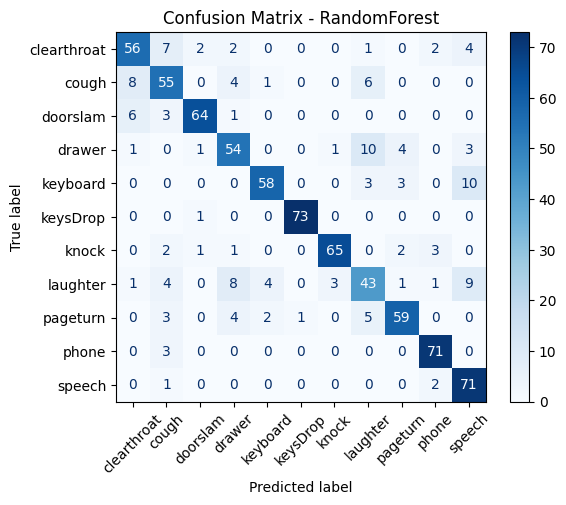


====== LogisticRegression ======


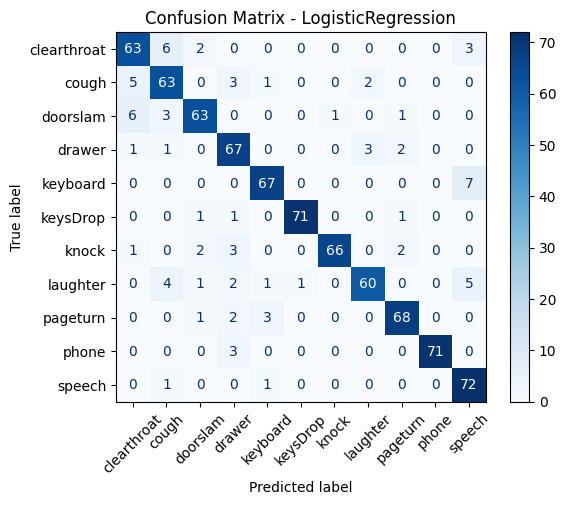


====== SVM ======


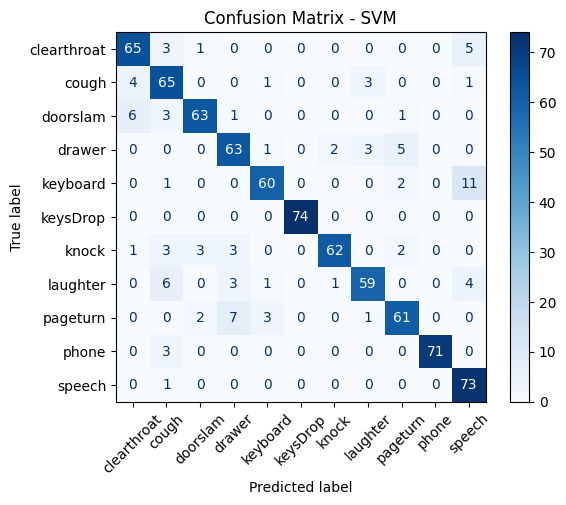


====== KNN ======


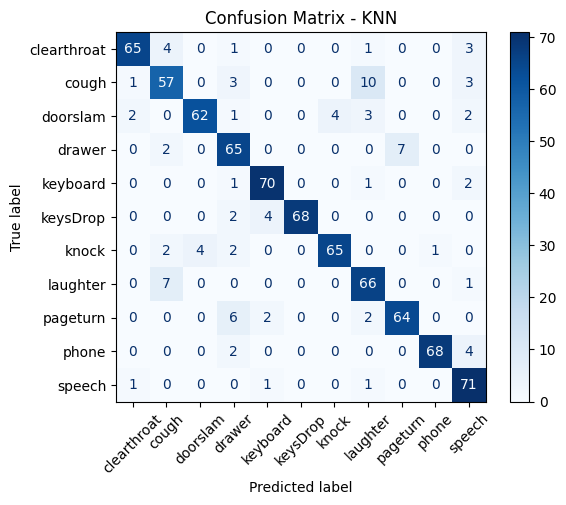


====== XGBoost ======


c:\Users\user\Downloads\SASED\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:44:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\Downloads\SASED\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:44:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\Downloads\SASED\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:44:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\Downloads\SASED\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:44:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_labe

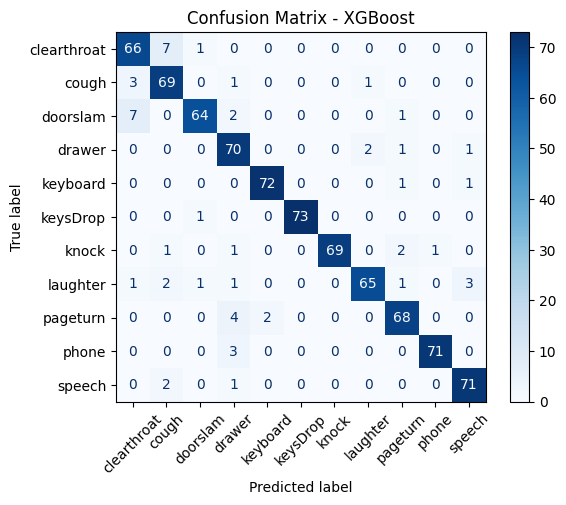


====== MLP ======


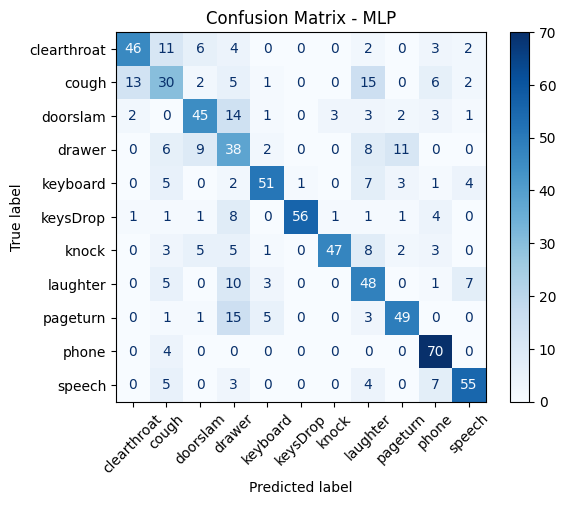

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Définir les modèles avec hyperparamètres adaptés
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=5, random_state=42),
    "LogisticRegression": LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', max_iter=2000),
    "SVM": SVC(C=1, kernel='rbf', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=3, weights='distance'),
    "XGBoost": XGBClassifier(use_label_encoder=False, n_estimators=100, max_depth=3, learning_rate=0.1,
                             subsample=0.8, colsample_bytree=0.8, objective='multi:softprob', eval_metric='mlogloss'),
    "MLP": MLPClassifier(hidden_layer_sizes=(32, 16), activation='relu', solver='adam',
                         alpha=0.001, max_iter=1000, early_stopping=True, random_state=42)
}

# Dictionnaire de résultats
results = {}

# K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation
for name, model in models.items():
    print(f"\n====== {name} ======")
    all_reports = []
    all_confusions = np.zeros((len(np.unique(y_encoded)), len(np.unique(y_encoded))), dtype=int)

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        new_X_train, new_X_test = X.iloc[train_idx], X.iloc[test_idx]
        new_y_train, new_y_test = y[train_idx], y[test_idx]

        model.fit(new_X_train, new_y_train)
        y_pred = model.predict(new_X_test)

        # Classification report
        report = classification_report(new_y_test, y_pred, output_dict=True, zero_division=0)
        all_reports.append(report)

        # Confusion matrix
        cm = confusion_matrix(new_y_test, y_pred)
        all_confusions += cm

    # Affichage de la matrice de confusion moyenne
    disp = ConfusionMatrixDisplay(confusion_matrix=all_confusions,
                                  display_labels=le.classes_)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # Moyenne des scores de classification
    avg_report = {}

    for label in all_reports[0].keys():
        if isinstance(all_reports[0][label], dict):  # On ignore 'accuracy' (float)
            avg_report[label] = {}
            for metric in all_reports[0][label].keys():
                avg_report[label][metric] = np.mean([r[label][metric] for r in all_reports])
        else:
            avg_report[label] = np.mean([r[label] for r in all_reports])


    results[name] = {
        "model": model,
        "report": avg_report
    }


In [15]:
for name, res in results.items():
    print(f"\n=== {name} ===")
    print(pd.DataFrame(res["report"]).T[["precision", "recall", "f1-score"]])


=== RandomForest ===
              precision    recall  f1-score
0              0.794866  0.757143  0.766364
1              0.708106  0.744762  0.718976
2              0.925000  0.863810  0.886994
3              0.737376  0.727619  0.726190
4              0.915873  0.785714  0.829482
5              0.986667  0.986667  0.986667
6              0.943663  0.878095  0.908199
7              0.633223  0.581905  0.605444
8              0.859707  0.798095  0.827367
9              0.901667  0.960000  0.928915
10             0.740386  0.958095  0.832494
accuracy       0.821813  0.821813  0.821813
macro avg      0.831503  0.821991  0.819736
weighted avg   0.831665  0.821813  0.819720

=== LogisticRegression ===
              precision    recall  f1-score
0              0.835729  0.851429  0.840459
1              0.825309  0.850476  0.831459
2              0.893485  0.849524  0.867097
3              0.851429  0.905714  0.870739
4              0.924706  0.906667  0.909876
5              0.986667  0

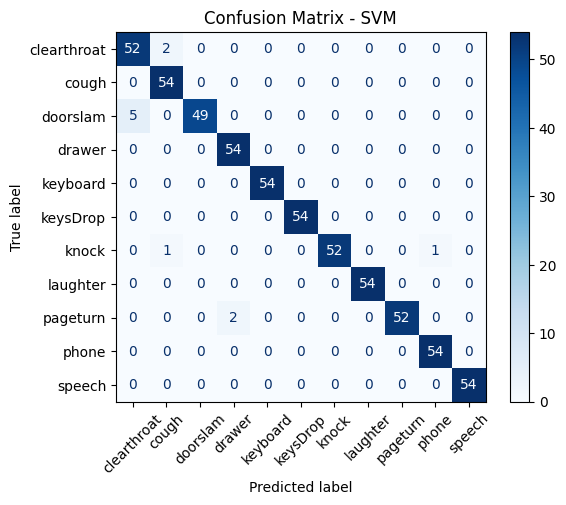

In [16]:
# Confusion matrix on validation set
from sklearn.metrics import ConfusionMatrixDisplay

best_model = results["XGBoost"]["model"]
y_pred = best_model.predict(X_val)
label_names = le.classes_

ConfusionMatrixDisplay.from_predictions(y_val, y_pred, display_labels=label_names, cmap='Blues')
plt.title("Confusion Matrix - SVM")
plt.xticks(rotation=45)
plt.show()

In [17]:
pd.DataFrame(classification_report(y_val, y_pred, output_dict=True, zero_division=0)).T

,precision,recall,f1-score,support
0,0.912281,0.962963,0.936937,54.000000
1,0.947368,1.000000,0.972973,54.000000
2,1.000000,0.907407,0.951456,54.000000
3,0.964286,1.000000,0.981818,54.000000
4,1.000000,1.000000,1.000000,54.000000
5,1.000000,1.000000,1.000000,54.000000
6,1.000000,0.962963,0.981132,54.000000
7,1.000000,1.000000,1.000000,54.000000
8,1.000000,0.962963,0.981132,54.000000
9,0.981818,1.000000,0.990826,54.000000


c:\Users\user\Downloads\SASED\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:20:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


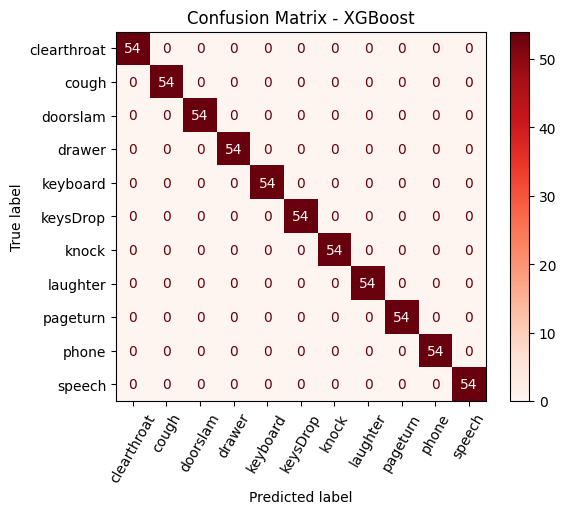

In [18]:
# Now we train the best model on the hole train dataset
best_model = models['XGBoost'].fit(X, y)

y_pred = best_model.predict(X_val)

ConfusionMatrixDisplay.from_predictions(y_val, y_pred, display_labels=label_names, cmap='Reds')
plt.title("Confusion Matrix - XGBoost")
plt.xticks(rotation=60)
plt.show()

In [19]:
joblib.dump(best_model, "best_multiclass_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [20]:
le.classes_

array(['clearthroat', 'cough', 'doorslam', 'drawer', 'keyboard',
       'keysDrop', 'knock', 'laughter', 'pageturn', 'phone', 'speech'],
      dtype='<U11')

In [29]:
pd.DataFrame(le.inverse_transform(y_pred))

,0
0,clearthroat
1,cough
2,pageturn
3,speech
4,keysDrop
...,...
589,drawer
590,phone
591,speech
592,knock


In [33]:
{"abcisses" : X['bandwidth_mean'],
 "ordonnées" : X['centroid_std']}

{'abcisses': 0     -0.187923
 1     -0.889054
 2     -1.379187
 3     -0.303379
 4     -0.738052
          ...   
 589    1.938842
 590    1.612645
 591    3.053433
 592    3.150211
 593    3.053779
 Name: bandwidth_mean, Length: 814, dtype: float64,
 'ordonnées': 0     -0.267051
 1     -1.327934
 2     -0.819605
 3      0.447873
 4      0.213276
          ...   
 589    0.661281
 590   -0.383261
 591    1.481318
 592    2.493068
 593    2.409906
 Name: centroid_std, Length: 814, dtype: float64}

In [34]:
def extract_features(y, sr):

    # Duration
    duration = librosa.get_duration(y=y, sr=sr)
    
    # Mel-frequency Cepstral Coefficients (MFCCs)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mel_spec = librosa.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000), ref=np.max)
    delta_mfcc = librosa.feature.delta(mfccs)

    # Chroma Features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    
    # Zero-crossing rate
    zcr = librosa.feature.zero_crossing_rate(y)
    
    # Spectral centroid : brightness of sound
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

    # Bandwidth : Spread of frequencies around the centroid
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)

    # Rolloff : Frequency below which a certain % of the total spectral energy lies
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)

    # Flatness : Tonal vs. noisy quality (close to 1: noisy)
    flatness = librosa.feature.spectral_flatness(y=y)

    # Contrast : Difference in energy between peaks and valleys in spectrum
    contrast = librosa.feature.spectral_contrast(y=y)
    
    # RMS energy
    rms = librosa.feature.rms(y=y)

    # tempo
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    

    return np.hstack([mfccs.mean(axis=1), chroma.mean(axis=1), zcr.std(), zcr.mean(), centroid.mean(), centroid.std(), rms.mean(), rms.std(),
                      bandwidth.mean(), bandwidth.std(), rolloff.mean(), rolloff.std(), flatness.mean(), flatness.std(), tempo,
                      contrast.mean(), contrast.std(), delta_mfcc.mean(axis=1), mel_spec.mean(), mel_spec.std(), duration])



def detect_audio_events(
    wav_path,
    extract_features = extract_features,
    sample_rate=44100,
    frame_length=2048,
    hop_length=512,
    energy_threshold=0.01,
    min_event_duration=0.1,
    max_event_duration=3.0
):
    """
    Detects and extracts events in an audio file using a simple energy threshold.
    
    Parameters:
        wav_path (str): Path to the input WAV file.
        extract_features (function): Function taking (y, sr) and returning a 1D feature vector
        sample_rate (int): Sampling rate to load the audio.
        frame_length (int): Number of samples per frame.
        hop_length (int): Hop length between frames.
        energy_threshold (float): Normalized energy threshold for event detection.
        min_event_duration (float): Minimum event duration in seconds.
        max_event_duration (float): Maximum event duration in seconds.
    
    Returns:
        pd.DataFrame: DataFrame containing onset and offset times of detected events.
    """
    # Load audio
    y, sr = librosa.load(wav_path, sr=sample_rate, mono=True)
    duration = librosa.get_duration(y=y, sr=sr)

    # Compute energy and thresholding
    frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length)
    energy = np.sum(frames**2, axis=0)
    energy_norm = energy / np.max(energy)
    mask = energy_norm > energy_threshold

    # Convert frame indices to time
    times = librosa.frames_to_time(np.arange(len(mask)), sr=sr, hop_length=hop_length)

    # Detect onsets and offsets
    onsets, offsets = [], []
    is_event = False
    start_time = None

    for i, active in enumerate(mask):
        if active and not is_event:
            is_event = True
            start_time = times[i]
        elif not active and is_event:
            end_time = times[i]
            is_event = False
            if (end_time - start_time) >= min_event_duration:
                onsets.append(start_time)
                offsets.append(min(end_time, start_time + max_event_duration))

    if is_event and (duration - start_time) >= min_event_duration:
        onsets.append(start_time)
        offsets.append(min(duration, start_time + max_event_duration))

    # Prepare DataFrame
    features_list = []
    for onset, offset in zip(onsets, offsets):
        start_sample = int(onset * sr)
        end_sample = int(offset * sr)
        segment = y[start_sample:end_sample]

        features = extract_features(segment, sr)
        features_list.append([onset, offset] + list(features))

    # columns names 
    feature_names = (
        [f"mfcc_{i+1}_mean" for i in range(13)] +
        [f"chroma_{i+1}_mean" for i in range(12)] +
        ["zcr_std", "zcr_mean"] +
        ["centroid_mean", "centroid_std"] +
        ["rms_mean", "rms_std"] +
        ["bandwidth_mean", "bandwidth_std"] +
        ["rolloff_mean", "rolloff_std"] +
        ["flatness_mean", "flatness_std"] +
        ["tempo"] +
        ["contrast_mean", "contrast_std"] +
        [f"delta_mfcc_{i+1}_mean" for i in range(13)] +
        ["mel_spec_mean", "mel_spec_std"] +
        ["duration"]
        )

    df = pd.DataFrame(features_list, columns=["onset", "offset"] + feature_names)
    print(f"✅ {len(df)} events detected and corresponding features are extracted...")
    return df

In [37]:
df = detect_audio_events(root_folder+'/test/sound/test_1_ebr_0_nec_1_poly_0.wav')

✅ 3 events detected and corresponding features are extracted...


In [46]:
tmp = df.drop(['offset', 'onset'], axis=1).columns
pd.DataFrame(scaler.transform(df.drop(['offset', 'onset'], axis=1)), columns=tmp)

,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,...,delta_mfcc_7_mean,delta_mfcc_8_mean,delta_mfcc_9_mean,delta_mfcc_10_mean,delta_mfcc_11_mean,delta_mfcc_12_mean,delta_mfcc_13_mean,mel_spec_mean,mel_spec_std,duration
0,-1.568039,-1.379004,1.436886,-0.039994,1.412042,-0.246429,1.248945,0.332658,0.483180,0.689570,...,-0.616607,-0.477407,-0.595450,-0.407395,-0.365723,-0.102149,-0.450655,0.607357,-1.785879,2.505190
1,-1.636305,-1.504153,1.364632,-0.177974,1.253969,-0.460845,1.202607,0.299253,0.487951,0.689581,...,-0.584238,-0.464218,-0.474018,-0.243734,-0.308630,-0.125983,-0.437318,1.297746,-2.013257,2.505190
2,-1.634414,-1.505593,1.352026,-0.244970,1.231168,-0.412123,1.216133,0.281718,0.483895,0.736585,...,-0.489131,-0.443768,-0.513110,-0.429274,-0.411013,-0.039787,-0.492759,1.455091,-2.035306,0.893251


In [ ]:
def detect_audio_events(
    wav_path,
    extract_features = extract_features,
    sample_rate=44100,
    min_event_duration = 0.3
):
    """
    Detects and extracts events in an audio file using a simple energy threshold.
    
    Parameters:
        wav_path (str): Path to the input WAV file.
        extract_features (function): Function taking (y, sr) and returning a 1D feature vector
        sample_rate (int): Sampling rate to load the audio.
        frame_length (int): Number of samples per frame.
        hop_length (int): Hop length between frames.
        energy_threshold (float): Normalized energy threshold for event detection.
        min_event_duration (float): Minimum event duration in seconds.
        max_event_duration (float): Maximum event duration in seconds.
    
    Returns:
        pd.DataFrame: DataFrame containing onset and offset times of detected events.
    """
    # Load audio
    y, sr = librosa.load(wav_path, sr=sample_rate, mono=True)
    duration = librosa.get_duration(y=y, sr=sr)

    # Detect onsets (automatic, not threshold-based)
    onset_frames = librosa.onset.onset_detect(y=y, sr=sr, backtrack=False)
    onsets = librosa.frames_to_time(onset_frames, sr=sample_rate)


    # Pair each onset with the next one as offset; last one ends at the end of audio
    offsets = []
    for i in range(len(onsets)):
        onset = onsets[i]
        offset = onsets[i+1] + min_event_duration if i+1 < len(onsets) else len(y) / sample_rate
        offsets.append(offset)

    # Prepare DataFrame
    features_list = []
    for onset, offset in zip(onsets, offsets):
        start_sample = int(onset * sr)
        end_sample = int(offset * sr)
        segment = y[start_sample:end_sample]

        features = extract_features(segment, sr)
        features_list.append([onset, offset] + list(features))

    # columns names 
    feature_names = (
        [f"mfcc_{i+1}_mean" for i in range(13)] +
        [f"chroma_{i+1}_mean" for i in range(12)] +
        ["zcr_std", "zcr_mean"] +
        ["centroid_mean", "centroid_std"] +
        ["rms_mean", "rms_std"] +
        ["bandwidth_mean", "bandwidth_std"] +
        ["rolloff_mean", "rolloff_std"] +
        ["flatness_mean", "flatness_std"] +
        ["tempo"] +
        ["contrast_mean", "contrast_std"] +
        [f"delta_mfcc_{i+1}_mean" for i in range(13)] +
        ["mel_spec_mean", "mel_spec_std"] +
        ["duration"]
        )

    df = pd.DataFrame(features_list, columns=["onset", "offset"] + feature_names)
    print(f"✅ {len(df)} events detected and corresponding features are extracted...")
    return df

In [70]:
df = detect_audio_events(root_folder+'/test/sound/test_1_ebr_0_nec_1_poly_0.wav')

✅ 42 events detected and corresponding features are extracted...


In [62]:
df

,onset,offset,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,...,delta_mfcc_7_mean,delta_mfcc_8_mean,delta_mfcc_9_mean,delta_mfcc_10_mean,delta_mfcc_11_mean,delta_mfcc_12_mean,delta_mfcc_13_mean,mel_spec_mean,mel_spec_std,duration
0,0.023220,3.023220,-521.536316,45.876411,48.035851,17.283373,31.272585,9.795248,15.413936,4.736632,...,0.016877,0.026001,0.015853,-0.006570,-0.003945,0.003922,0.007110,-40.237328,8.600744,3.000000
1,0.510839,3.510839,-521.477783,45.817524,47.676804,17.045477,30.836271,9.667233,15.148439,4.571479,...,0.016392,0.027450,0.011005,0.011263,0.021950,0.006247,0.014649,-40.228050,8.550151,3.000000
2,8.568163,11.568163,-512.028564,48.114040,40.584179,12.538009,27.479191,8.414283,15.203685,4.535948,...,0.005560,0.036924,-0.013529,-0.014601,-0.040685,-0.039228,-0.026916,-40.437611,9.062852,3.000000
3,8.893243,11.893243,-518.057922,46.492725,43.452419,13.230148,28.332409,8.723093,15.106687,4.416310,...,0.042690,-0.009252,-0.031206,0.005190,0.007803,-0.022225,0.027622,-37.542366,8.576013,3.000023
4,9.020952,12.020952,-522.891418,44.520573,45.697906,14.095259,28.525341,8.819668,15.318769,4.392636,...,0.005544,0.043355,0.011361,0.051707,0.034430,-0.029297,-0.024035,-34.868908,8.168008,3.000023
5,24.473832,27.473832,-524.619080,43.391766,47.032352,15.728683,28.796778,8.497853,14.867012,3.666153,...,-0.056081,-0.037760,-0.003093,-0.003238,-0.004738,-0.006611,-0.042295,-32.647213,8.149464,3.000000
6,27.898776,30.898776,-498.384430,42.589287,40.011688,15.115636,16.495277,8.550110,17.986698,9.099957,...,-0.003247,-0.046565,-0.031179,-0.005188,-0.038184,-0.003772,0.045193,-31.888536,8.660514,3.000000
7,28.490884,31.490884,-512.883789,43.053982,43.623516,15.379871,23.857437,8.483447,16.428064,6.529706,...,-0.039131,-0.068410,-0.012652,0.026125,-0.008448,0.018325,-0.023153,-33.264626,8.436531,3.000000
8,33.622494,36.622494,-500.805511,44.598366,33.840313,15.480401,29.769342,6.807160,11.964416,5.664649,...,0.105563,-0.077733,-0.012995,0.031469,0.042816,0.015352,0.027639,-39.227520,9.050872,3.000000
9,33.726984,36.726984,-504.730957,44.174431,35.294041,15.619853,30.348463,7.252970,12.410448,5.227777,...,0.064076,-0.034117,-0.028506,-0.030731,-0.015187,-0.043873,-0.022819,-34.481419,8.762251,3.000000
